# Thermal Discrete Dipole Approximation

In this code, we implement the TDDA method to obtain the emissivity and emitted power of different objects.

## General imports

In [2]:
# Libraries needed to import for this example

import numpy as np                    # Basic numerical python library
import matplotlib.pyplot as plt       # Plotting library for python

# Silica permittivity

real_epsilon_SiO2 = np.genfromtxt('Datasets/epsilon_real_SiO2.dat') # Real part of silica permittivity
imag_epsilon_SiO2 = np.genfromtxt('Datasets/epsilon_imag_SiO2.dat') # Imaginary part of silica permittivity

wSiO2_raw = real_epsilon_SiO2[:,0]/(6.58*10**(-16)*10**14) # Sampling frequencies for silica permittivity raw, 10^14 rad/s
eps_SiO2_raw = real_epsilon_SiO2[:,1]+1j*imag_epsilon_SiO2[:,1] # Full silica permittivity raw

wSiO2 = np.linspace(0.2,3,200) # Sampling frequencies for silica permittivity, 10^14 rad/s
eps_SiO2 = np.interp(wSiO2,wSiO2_raw,eps_SiO2_raw) # Full silica permittivity

In [2]:
# Function definitons

c = 3*10**8 
hbar = 1.055*10**(-34)
kB = 1.38*10**(-23)

def IBB(w,T): # Planck's distribution function
    
    result = (w**2)/(4*np.pi**3*c**2)*(hbar*w)/(np.exp((hbar*w)/(kB*T))-1)
    
    return result

def Gfunct(r1,r2,k): # Calculate the Green's function matrix from dipole 1 to dipole 2
    
    Rd = np.linalg.norm(r1-r2) # Distance between the dipoles
    
    GfA = (1+(1j*k*Rd-1)/(k**2*Rd**2))*np.identity(3)
    GfB = ((3-3j*k*Rd-k**2*Rd**2)/(k**2*Rd**2))*((np.outer(r1-r2,r1-r2))/(Rd**2))
    result = (GfA+GfB)*(np.exp(1j*k*Rd))/(4*np.pi*Rd)
    
    return result

## Single dipole

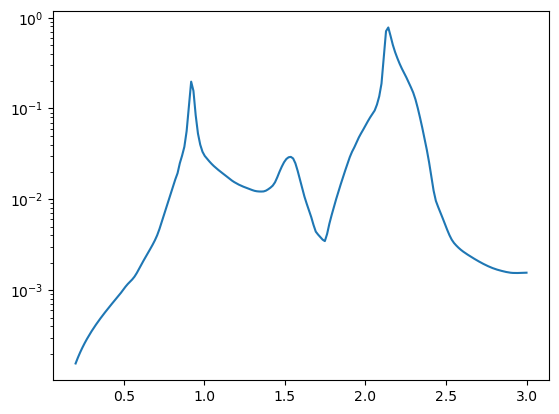

In [7]:
# Pre-allocations and constants

Nw = wSiO2.shape[0] # Number of frequency points
R = 100 # Radius of spherical dipole, in nm
Vd = 4/3*np.pi*(R*10**(-9))**3 # Volume of the spherical dipole
T = 300 # Temperature in Kelvin

emission = np.zeros((Nw,)) # Will hold the emissivity values
power = np.zeros((Nw,)) # Will hold the emission power values

# TDDA Calculations

for i in range(Nw):
    
    k0 = wSiO2[i]*10**14/c # K value 
    
    a0 = 3*Vd*(eps_SiO2[i]-1)/(eps_SiO2[i]+2) # Quasistatic polarizability tensor
    a = (a0)/(1-1j*k0**3*((a0)/(6*np.pi))) # Full polarizability tensor
    
    xi = np.imag(a)-(k0**3)/(6*np.pi)*np.abs(a)**2 
    
    emission_raw = k0*xi # Emission cross-section of the dipole
    emission[i] = emission_raw/(np.pi*(R*10**(-9))**2) # Emissivity of the dipole
    
    power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T)

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(wSiO2,emission)
axs.set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs.set_ylabel('Emissivity', fontsize = 20)
axs.set_yscale('log')
axs.tick_params(axis='both', labelsize = 20)
fig.savefig('TDDA_single_dipole.png', format='png', dpi=600)
plt.show()

## Cube emissivity

/tmp/ipykernel_10384/2140029071.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  emission[i] = emission_raw/((L*10**(-9))**2) # Emissivity of the cube
/tmp/ipykernel_10384/2140029071.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
  power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube


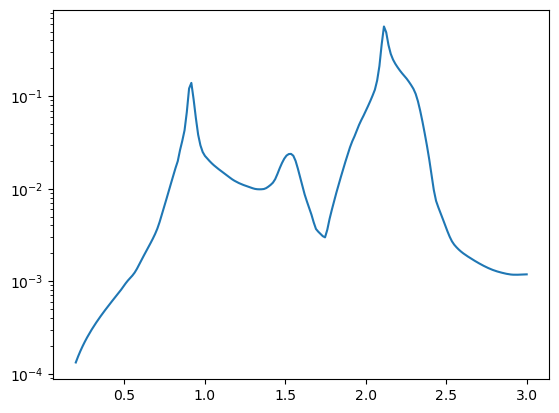

In [15]:
# Pre-allocations and constants

Nw = wSiO2.shape[0] # Number of frequency points
T = 300 # Temperature in Kelvin

N = 125 # Number of dipoles to consider
Ns = int(np.cbrt(N)) # Number of dipoles per side
L = 100 # Cube side in nm
Ln = L/Ns # Side of the cubical dipoles forming the object 
Vn = (Ln*10**(-9))**3; # Dipole cube volume, in SI

emission = np.zeros((Nw,)) # Will hold the emissivity values
power = np.zeros((Nw,)) # Will hold the emission power values

# TDDA calculations

# Distributing the dipoles in space to form the cube

posit = np.zeros((N,3)) # Holds all the positions

maxim = np.floor(Ns/2) # How many dipoles until reaching the end of the sides

for i in range(Ns):
    
    for j in range(Ns):
        
        for k in range(Ns):
            
            indexr = k + j*Ns + i*Ns**2
            
            posit[indexr,:] = np.array([i-maxim,j-maxim,k-maxim])

posit = posit*Ln*10**(-9); # Actual locations of the cubes in SI

# Calculate the emissivity and power

for i in range(Nw):
    
    GG = np.zeros((3*N,3*N)).astype('complex'); # Pre-allocating the Green matrices
    dG = np.zeros((3*N,3*N)).astype('complex');
    
    # All dipoles are cubic, isotropic and equal in size: same a0,a,xi, and are diagonal
    
    k0 = wSiO2[i]*10**14/c # k value
    
    a0 = 3*Vn*(eps_SiO2[i]-1)/(eps_SiO2[i]+2) # Quasistatic polarizability tensor
    a = (a0)/(1-1j*k0**3*((a0)/(6*np.pi))) # Full polarizability tensor
    
    xi = np.imag(a)-(k0**3)/(6*np.pi)*np.abs(a)**2 
    
    AA = a*np.identity(3*N) # Full polarizabilty matrix
    XXi = xi*np.identity(3*N)
    
    # Calculate the Green's function values
    
    for j in range(N):
        
        for k in range(N):
            
            index_j = np.array([[3*j,3*j,3*j],[3*j+1,3*j+1,3*j+1],[3*j+2,3*j+2,3*j+2]]).astype(int)
            index_k = np.array([[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2]]).astype(int)
            
            if j == k:
                
                GG[index_k,index_j] = ((-1)/(3*k0**2*Vn)+(1j*k0)/(6*np.pi))*np.identity(3)
                
            else:
                
                tempG = Gfunct(posit[j,:],posit[k,:],k0)
                GG[index_k,index_j] = tempG
                dG[index_k,index_j] = tempG
    
    D = np.linalg.inv(np.identity(3*N)-k0**2*np.matmul(dG,AA))
    
    emission_raw = 2*np.pi*np.trace(np.matmul(D,np.matmul(np.imag(GG),np.matmul(np.conjugate(np.transpose(D)),XXi))))
    
    emission[i] = emission_raw/((L*10**(-9))**2) # Emissivity of the cube
    
    power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube
    
    total_emiss = np.sum(power)*(wSiO2[1]-wSiO2[0])*10**14/(6*(L*10**(-9))**2*5.67*10**(-8)*T**4) # Total emissivity of the cube
    
plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(wSiO2,emission)
axs.set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs.set_ylabel('Emissivity', fontsize = 20)
axs.set_yscale('log')
axs.tick_params(axis='both', labelsize = 20)
fig.savefig('TDDA_cube_emissivity.png', format='png', dpi=600)
plt.show()

In [16]:
# Pre-allocations and constants

Nw = wSiO2.shape[0] # Number of frequency points
T = 300 # Temperature in Kelvin

n_vect = np.array([1**3,3**3,5**3,7**3,9**3]) # Number of dipoles to use

L = 3000 # Cube side in nm

emis_to_plot = np.zeros((5,Nw))
power_to_plot = np.zeros((5,))

for ape in range(5):

    N = n_vect[ape] # Number of dipoles to consider
    Ns = int(np.cbrt(N)) # Number of dipoles per side
    Ln = L/Ns # Side of the cubical dipoles forming the object 
    Vn = (Ln*10**(-9))**3; # Dipole cube volume, in SI
    
    emission = np.zeros((Nw,)) # Will hold the emissivity values
    power = np.zeros((Nw,)) # Will hold the emission power values
    
    # TDDA calculations
    
    # Distributing the dipoles in space to form the cube
    
    posit = np.zeros((N,3)) # Holds all the positions
    
    maxim = np.floor(Ns/2) # How many dipoles until reaching the end of the sides
    
    for i in range(Ns):
        
        for j in range(Ns):
            
            for k in range(Ns):
                    
                indexr = k + j*Ns + i*Ns**2
                
                posit[indexr,:] = np.array([i-maxim,j-maxim,k-maxim])
    
    posit = posit*Ln*10**(-9); # Actual locations of the cubes in SI

    # Calculate the emissivity and power

    for i in range(Nw):
    
        GG = np.zeros((3*N,3*N)).astype('complex'); # Pre-allocating the Green matrices
        dG = np.zeros((3*N,3*N)).astype('complex');
    
        # All dipoles are cubic, isotropic and equal in size: same a0,a,xi, and are diagonal
    
        k0 = wSiO2[i]*10**14/c # k value
    
        a0 = 3*Vn*(eps_SiO2[i]-1)/(eps_SiO2[i]+2) # Quasistatic polarizability tensor
        a = (a0)/(1-1j*k0**3*((a0)/(6*np.pi))) # Full polarizability tensor
    
        xi = np.imag(a)-(k0**3)/(6*np.pi)*np.abs(a)**2 
    
        AA = a*np.identity(3*N) # Full polarizabilty matrix
        XXi = xi*np.identity(3*N)
    
        # Calculate the Green's function values
    
        for j in range(N):
        
            for k in range(N):
            
                index_j = np.array([[3*j,3*j,3*j],[3*j+1,3*j+1,3*j+1],[3*j+2,3*j+2,3*j+2]]).astype(int)
                index_k = np.array([[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2]]).astype(int)
            
                if j == k:
                
                    GG[index_k,index_j] = ((-1)/(3*k0**2*Vn)+(1j*k0)/(6*np.pi))*np.identity(3)
                
                else:
                
                    tempG = Gfunct(posit[j,:],posit[k,:],k0)
                    GG[index_k,index_j] = tempG
                    dG[index_k,index_j] = tempG
        
        D = np.linalg.inv(np.identity(3*N)-k0**2*np.matmul(dG,AA))
    
        emission_raw = 2*np.pi*np.trace(np.matmul(D,np.matmul(np.imag(GG),np.matmul(np.conjugate(np.transpose(D)),XXi))))
    
        emission[i] = emission_raw/((L*10**(-9))**2) # Emissivity of the cube
    
        power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube
    
    total_emiss = np.sum(power)*(wSiO2[1]-wSiO2[0])*10**14/(6*(L*10**(-9))**2*5.67*10**(-8)*T**4) # Total emissivity of the cube
    
    emis_to_plot[ape,:] = np.reshape(emission,(1,Nw))
    power_to_plot[ape] = total_emiss


/tmp/ipykernel_10384/2330026781.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  emission[i] = emission_raw/((L*10**(-9))**2) # Emissivity of the cube
/tmp/ipykernel_10384/2330026781.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube


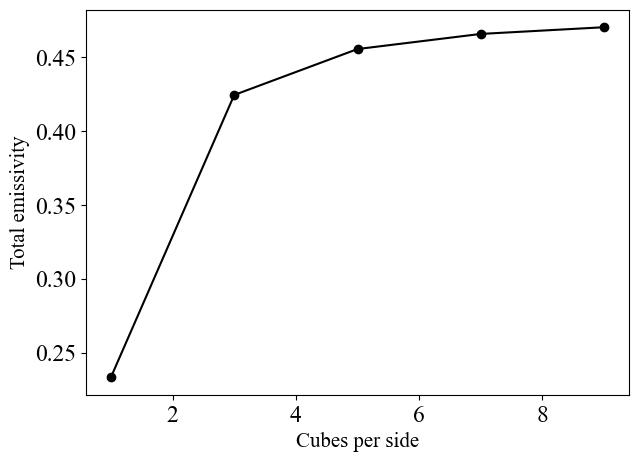

In [17]:
plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(np.array([1,3,5,7,9]),power_to_plot,'-o',color='black',)
axs.set_ylabel('Total emissivity', fontsize = 20)
axs.set_xlabel('Cubes per side', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
fig.savefig('TDDA_cube_pow_conv.png', format='png', dpi=600)
plt.show()

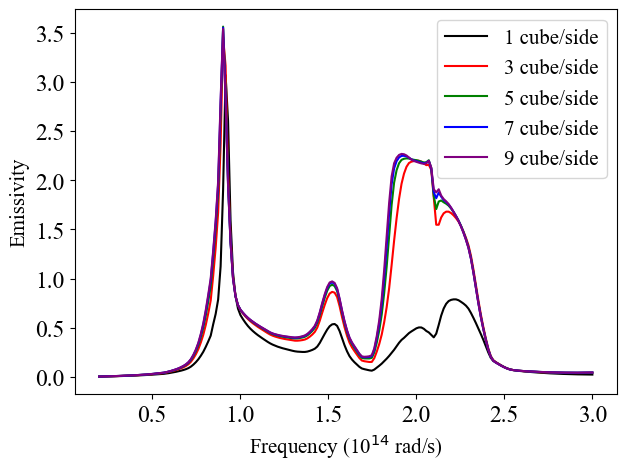

In [22]:
plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(wSiO2,emis_to_plot[0,:],color='black')
axs.plot(wSiO2,emis_to_plot[1,:],color='red')
axs.plot(wSiO2,emis_to_plot[2,:],color='green')
axs.plot(wSiO2,emis_to_plot[3,:],color='blue')
axs.plot(wSiO2,emis_to_plot[4,:],color='purple')
axs.set_ylabel('Emissivity', fontsize = 20)
axs.set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['1 cube/side','3 cube/side','5 cube/side','7 cube/side','9 cube/side'], loc='upper right', fontsize = 20)
fig.savefig('TDDA_cube_emis_conv.png', format='png', dpi=600)
plt.show()

## Sphere emissivity

In [ ]:
# Pre-allocations and constants

Nw = wSiO2.shape[0] # Number of frequency points
T = 300 # Temperature in Kelvin

N = 125 # Number of dipoles to consider
Ns = int(np.cbrt(N)) # Number of dipoles per side of the cube
L = 10 # Cube side in nm (diameter of the sphere)
Ln = L/Ns # Side of the cubical dipoles forming the object 
Vn = (Ln*10**(-9))**3; # Dipole cube volume, in SI

emission = np.zeros((Nw,)) # Will hold the emissivity values
power = np.zeros((Nw,)) # Will hold the emission power values

# TDDA calculations

# Distributing the dipoles in space to form the cube

maxim = np.floor(Ns/2) # How many dipoles until reaching the end of the sides

R = N/2

posit = [] # Holds all the positions

for i in range(Ns):
    
    for j in range(Ns):
        
        for k in range(Ns):
            
            vector = np.array([i-maxim,j-maxim,k-maxim])
            
            if np.linalg.norm(vector) <= R:
            
                indexr = k + j*Ns + i*Ns**2
                posit.append(vector*Ln*10**(-9)) # Actual locations of the cubes in SI

N = len(posit)

# Calculate the emissivity and power

for i in range(Nw):
    
    GG = np.zeros((3*N,3*N)).astype('complex'); # Pre-allocating the Green matrices
    dG = np.zeros((3*N,3*N)).astype('complex');
    
    # All dipoles are cubic, isotropic and equal in size: same a0,a,xi, and are diagonal
    
    k0 = wSiO2[i]*10**14/c # k value
    
    a0 = 3*Vn*(eps_SiO2[i]-1)/(eps_SiO2[i]+2) # Quasistatic polarizability tensor
    a = (a0)/(1-1j*k0**3*((a0)/(6*np.pi))) # Full polarizability tensor
    
    xi = np.imag(a)-(k0**3)/(6*np.pi)*np.abs(a)**2 
    
    AA = a*np.identity(3*N) # Full polarizabilty matrix
    XXi = xi*np.identity(3*N)
    
    # Calculate the Green's function values
    
    for j in range(N):
        
        for k in range(N):
            
            index_j = np.array([[3*j,3*j,3*j],[3*j+1,3*j+1,3*j+1],[3*j+2,3*j+2,3*j+2]]).astype(int)
            index_k = np.array([[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2]]).astype(int)
            
            if j == k:
                
                GG[index_k,index_j] = ((-1)/(3*k0**2*Vn)+(1j*k0)/(6*np.pi))*np.identity(3)
                
            else:
                
                tempG = Gfunct(posit[j][:],posit[k][:],k0)
                GG[index_k,index_j] = tempG
                dG[index_k,index_j] = tempG
    
    D = np.linalg.inv(np.identity(3*N)-k0**2*np.matmul(dG,AA))
    
    emission_raw = 2*np.pi*np.trace(np.matmul(D,np.matmul(np.imag(GG),np.matmul(np.conjugate(np.transpose(D)),XXi))))
    
    emission[i] = emission_raw/((L*10**(-9))**2) # Emissivity of the cube
    
    power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube
    
    total_emiss = np.sum(power)*(wSiO2[1]-wSiO2[0])*10**14/(6*(L*10**(-9))**2*5.67*10**(-8)*T**4) # Total emissivity of the cube
    
plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(wSiO2,emission)
axs.set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs.set_ylabel('Emissivity', fontsize = 20)
axs.set_yscale('log')
axs.tick_params(axis='both', labelsize = 20)
fig.savefig('TDDA_sphere_emissivity.png', format='png', dpi=600)
plt.show()

/tmp/ipykernel_10384/2215104882.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  emission[i] = emission_raw/((L*10**(-9))**2) # Emissivity of the cube
/tmp/ipykernel_10384/2215104882.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube


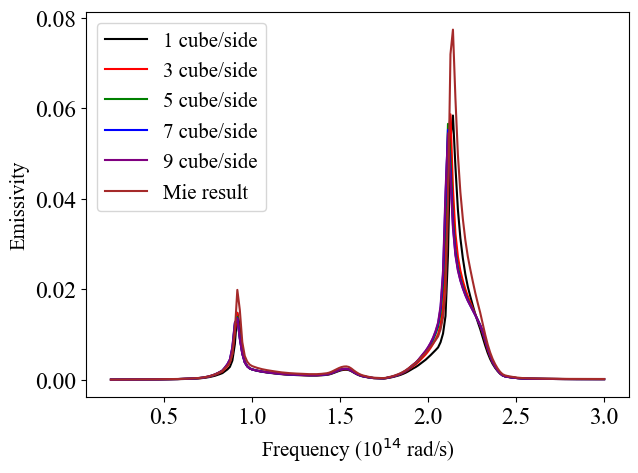

In [26]:
# Pre-allocations and constants

Nw = wSiO2.shape[0] # Number of frequency points
T = 300 # Temperature in Kelvin

n_vect = np.array([1**3,3**3,5**3,7**3,9**3]) # Number of dipoles to use

emis_to_plot = np.zeros((5,Nw))
power_to_plot = np.zeros((5,))

for ape in range(5):

    N = n_vect[ape] # Number of dipoles to consider
    Ns = int(np.cbrt(N)) # Number of dipoles per side
    L = 10 # Cube side in nm
    Ln = L/Ns # Side of the cubical dipoles forming the object 
    Vn = (Ln*10**(-9))**3; # Dipole cube volume, in SI
    
    emission = np.zeros((Nw,)) # Will hold the emissivity values
    power = np.zeros((Nw,)) # Will hold the emission power values
    
    # TDDA calculations
    
    # Distributing the dipoles in space to form the cube
    
    maxim = np.floor(Ns/2) # How many dipoles until reaching the end of the sides

    R = N/2

    posit = [] # Holds all the positions

    for i in range(Ns):
    
        for j in range(Ns):
        
            for k in range(Ns):
            
                vector = np.array([i-maxim,j-maxim,k-maxim])
            
                if np.linalg.norm(vector) <= R:
            
                    indexr = k + j*Ns + i*Ns**2
                    posit.append(vector*Ln*10**(-9)) # Actual locations of the cubes in SI

    N = len(posit)

    # Calculate the emissivity and power

    for i in range(Nw):
    
        GG = np.zeros((3*N,3*N)).astype('complex'); # Pre-allocating the Green matrices
        dG = np.zeros((3*N,3*N)).astype('complex');
    
        # All dipoles are cubic, isotropic and equal in size: same a0,a,xi, and are diagonal
    
        k0 = wSiO2[i]*10**14/c # k value
    
        a0 = 3*Vn*(eps_SiO2[i]-1)/(eps_SiO2[i]+2) # Quasistatic polarizability tensor
        a = (a0)/(1-1j*k0**3*((a0)/(6*np.pi))) # Full polarizability tensor
    
        xi = np.imag(a)-(k0**3)/(6*np.pi)*np.abs(a)**2 
    
        AA = a*np.identity(3*N) # Full polarizabilty matrix
        XXi = xi*np.identity(3*N)
    
        # Calculate the Green's function values
    
        for j in range(N):
        
            for k in range(N):
            
                index_j = np.array([[3*j,3*j,3*j],[3*j+1,3*j+1,3*j+1],[3*j+2,3*j+2,3*j+2]]).astype(int)
                index_k = np.array([[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2]]).astype(int)
            
                if j == k:
                
                    GG[index_k,index_j] = ((-1)/(3*k0**2*Vn)+(1j*k0)/(6*np.pi))*np.identity(3)
                
                else:
                
                    tempG = Gfunct(posit[j][:],posit[k][:],k0)
                    GG[index_k,index_j] = tempG
                    dG[index_k,index_j] = tempG
        
        D = np.linalg.inv(np.identity(3*N)-k0**2*np.matmul(dG,AA))
    
        emission_raw = 2*np.pi*np.trace(np.matmul(D,np.matmul(np.imag(GG),np.matmul(np.conjugate(np.transpose(D)),XXi))))
    
        emission[i] = emission_raw/((L*10**(-9))**2) # Emissivity of the cube
    
        power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube
    
    total_emiss = np.sum(power)*(wSiO2[1]-wSiO2[0])*10**14/(6*(L*10**(-9))**2*5.67*10**(-8)*T**4) # Total emissivity of the cube
    
    emis_to_plot[ape,:] = np.reshape(emission,(1,Nw))
    power_to_plot[ape] = total_emiss
    
Mie = np.genfromtxt('Datasets/Mie_data.dat')

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(wSiO2,emis_to_plot[0,:],color='black')
axs.plot(wSiO2,emis_to_plot[1,:],color='red')
axs.plot(wSiO2,emis_to_plot[2,:],color='green')
axs.plot(wSiO2,emis_to_plot[3,:],color='blue')
axs.plot(wSiO2,emis_to_plot[4,:],color='purple')
axs.plot(wSiO2,Mie[0,:],color='brown')
axs.set_ylabel('Emissivity', fontsize = 20)
axs.set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['1 cube/side','3 cube/side','5 cube/side','7 cube/side','9 cube/side','Mie result'], loc='upper left', fontsize = 20)
fig.savefig('TDDA_sphere_emis_conv_10.png', format='png', dpi=600)
plt.show()

## Parallelepid emissivity

In [ ]:
# Pre-allocations and constants

Nw = wSiO2.shape[0] # Number of frequency points
T = 300 # Temperature in Kelvin

Lx = 500 # X size of object, nm
Ly = 500 # Y size of object, nm
Lz = 2000 # Z size of object, nm

Ln = 125 # Side of the dipole cubes, must be divisor of all three sides
Vn = (Ln*10**(-9))**3; # Dipole cube volume, in SI

N = int(Lx*Ly*Lz/(Ln)**3) # Total number of dipoles

Nx = int(Lx/Ln) # Number of dipoles in the x direction
Ny = int(Ly/Ln) # Number of dipoles in the y direction
Nz = int(Lz/Ln) # Number of dipoles in the z direction

emission = np.zeros((Nw,)) # Will hold the emissivity values
power = np.zeros((Nw,)) # Will hold the emission power values

# TDDA calculations

# Distributing the dipoles in space to form the cube

posit = np.zeros((N,3)) # Holds all the positions

maximx = np.floor(Nx/2) # How many dipoles until reaching the end of the x side
maximy = np.floor(Ny/2) # How many dipoles until reaching the end of the y side
maximz = np.floor(Nz/2) # How many dipoles until reaching the end of the z side

for i in range(Nx):
    
    for j in range(Ny):
        
        for k in range(Nz):
            
            indexr = k + j*Nz + i*Nz*Ny
            
            posit[indexr,:] = np.array([i-maximx,j-maximy,k-maximz])

posit = posit*Ln*10**(-9); # Actual locations of the cubes in SI

# Calculate the emissivity and power

for i in range(Nw):
    
    GG = np.zeros((3*N,3*N)).astype('complex'); # Pre-allocating the Green matrices
    dG = np.zeros((3*N,3*N)).astype('complex');
    
    # All dipoles are cubic, isotropic and equal in size: same a0,a,xi, and are diagonal
    
    k0 = wSiO2[i]*10**14/c # k value
    
    a0 = 3*Vn*(eps_SiO2[i]-1)/(eps_SiO2[i]+2) # Quasistatic polarizability tensor
    a = (a0)/(1-1j*k0**3*((a0)/(6*np.pi))) # Full polarizability tensor
    
    xi = np.imag(a)-(k0**3)/(6*np.pi)*np.abs(a)**2 
    
    AA = a*np.identity(3*N) # Full polarizabilty matrix
    XXi = xi*np.identity(3*N)
    
    # Calculate the Green's function values
    
    for j in range(N):
        
        for k in range(N):
            
            index_j = np.array([[3*j,3*j,3*j],[3*j+1,3*j+1,3*j+1],[3*j+2,3*j+2,3*j+2]]).astype(int)
            index_k = np.array([[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2]]).astype(int)
            
            if j == k:
                
                GG[index_k,index_j] = ((-1)/(3*k0**2*Vn)+(1j*k0)/(6*np.pi))*np.identity(3)
                
            else:
                
                tempG = Gfunct(posit[j,:],posit[k,:],k0)
                GG[index_k,index_j] = tempG
                dG[index_k,index_j] = tempG
    
    D = np.linalg.inv(np.identity(3*N)-k0**2*np.matmul(dG,AA))
    
    emission_raw = 2*np.pi*np.trace(np.matmul(D,np.matmul(np.imag(GG),np.matmul(np.conjugate(np.transpose(D)),XXi))))
    
    emission[i] = emission_raw/((L*10**(-9))**2) # Emissivity of the cube
    
    power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube
    
    total_emiss = np.sum(power)*(wSiO2[1]-wSiO2[0])*10**14/(6*(L*10**(-9))**2*5.67*10**(-8)*T**4) # Total emissivity of the cube
    
plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(wSiO2,emission)
axs.set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs.set_ylabel('Emissivity', fontsize = 20)
axs.set_yscale('log')
axs.tick_params(axis='both', labelsize = 20)
fig.savefig('TDDA_parallel_emissivity.png', format='png', dpi=600)
plt.show()

/tmp/ipykernel_10384/1301982726.py:93: ComplexWarning: Casting complex values to real discards the imaginary part
  emission[i] = emission_raw/((L*10**(-9))**2) # Emissivity of the cube
/tmp/ipykernel_10384/1301982726.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube


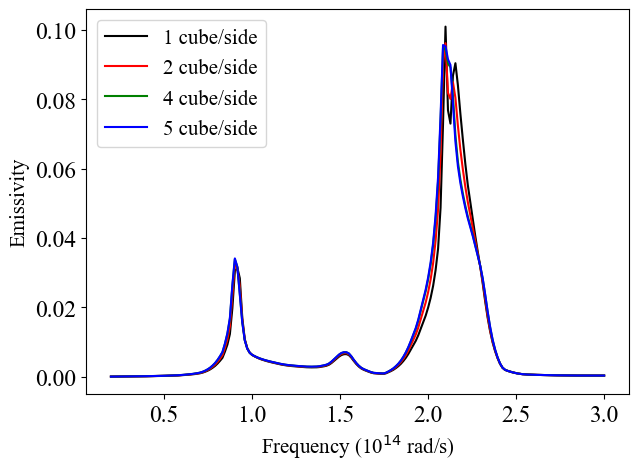

In [24]:
# Pre-allocations and constants

Nw = wSiO2.shape[0] # Number of frequency points
T = 300 # Temperature in Kelvin

Lx = 500 # X size of object, nm
Ly = 500 # Y size of object, nm
Lz = 1000 # Z size of object, nm

Ln_vect = np.array([500,250,125,100]) # Sizes of the cubes

emis_to_plot = np.zeros((4,Nw))
power_to_plot = np.zeros((4,))

for ape in range(4):
    
    Ln = Ln_vect[ape] # Side of the dipole cubes, must be divisor of all three sides
    Vn = (Ln*10**(-9))**3; # Dipole cube volume, in SI

    N = int(Lx*Ly*Lz/(Ln)**3) # Total number of dipoles

    Nx = int(Lx/Ln) # Number of dipoles in the x direction
    Ny = int(Ly/Ln) # Number of dipoles in the y direction
    Nz = int(Lz/Ln) # Number of dipoles in the z direction
    
    emission = np.zeros((Nw,)) # Will hold the emissivity values
    power = np.zeros((Nw,)) # Will hold the emission power values
    
    # TDDA calculations
    
    # Distributing the dipoles in space to form the cube
    
    posit = np.zeros((N,3)) # Holds all the positions

    maximx = np.floor(Nx/2) # How many dipoles until reaching the end of the x side
    maximy = np.floor(Ny/2) # How many dipoles until reaching the end of the y side
    maximz = np.floor(Nz/2) # How many dipoles until reaching the end of the z side

    for i in range(Nx):
    
        for j in range(Ny):
        
            for k in range(Nz):
            
                indexr = k + j*Nz + i*Nz*Ny
            
                posit[indexr,:] = np.array([i-maximx,j-maximy,k-maximz])

    posit = posit*Ln*10**(-9); # Actual locations of the cubes in SI

    # Calculate the emissivity and power

    for i in range(Nw):
    
        GG = np.zeros((3*N,3*N)).astype('complex'); # Pre-allocating the Green matrices
        dG = np.zeros((3*N,3*N)).astype('complex');
    
        # All dipoles are cubic, isotropic and equal in size: same a0,a,xi, and are diagonal
    
        k0 = wSiO2[i]*10**14/c # k value
    
        a0 = 3*Vn*(eps_SiO2[i]-1)/(eps_SiO2[i]+2) # Quasistatic polarizability tensor
        a = (a0)/(1-1j*k0**3*((a0)/(6*np.pi))) # Full polarizability tensor
    
        xi = np.imag(a)-(k0**3)/(6*np.pi)*np.abs(a)**2 
    
        AA = a*np.identity(3*N) # Full polarizabilty matrix
        XXi = xi*np.identity(3*N)
    
        # Calculate the Green's function values
    
        for j in range(N):
        
            for k in range(N):
            
                index_j = np.array([[3*j,3*j,3*j],[3*j+1,3*j+1,3*j+1],[3*j+2,3*j+2,3*j+2]]).astype(int)
                index_k = np.array([[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2]]).astype(int)
            
                if j == k:
                
                    GG[index_k,index_j] = ((-1)/(3*k0**2*Vn)+(1j*k0)/(6*np.pi))*np.identity(3)
                
                else:
                
                    tempG = Gfunct(posit[j,:],posit[k,:],k0)
                    GG[index_k,index_j] = tempG
                    dG[index_k,index_j] = tempG
        
        D = np.linalg.inv(np.identity(3*N)-k0**2*np.matmul(dG,AA))
    
        emission_raw = 2*np.pi*np.trace(np.matmul(D,np.matmul(np.imag(GG),np.matmul(np.conjugate(np.transpose(D)),XXi))))
    
        emission[i] = emission_raw/((L*10**(-9))**2) # Emissivity of the cube
    
        power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube
    
    total_emiss = np.sum(power)*(wSiO2[1]-wSiO2[0])*10**14/((2*Lx*10**(-9)*Ly*10**(-9)+4*Lx*10**(-9)*Lz*10**(-9))*5.67*10**(-8)*T**4) # Total emissivity of the cube
    
    emis_to_plot[ape,:] = np.reshape(emission,(1,Nw))
    power_to_plot[ape] = total_emiss

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(wSiO2,emis_to_plot[0,:],color='black')
axs.plot(wSiO2,emis_to_plot[1,:],color='red')
axs.plot(wSiO2,emis_to_plot[2,:],color='green')
axs.plot(wSiO2,emis_to_plot[3,:],color='blue')
axs.set_ylabel('Emissivity', fontsize = 20)
axs.set_xlabel('Frequency (10$^{14}$ rad/s)', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
axs.legend(['1 cube/side','2 cube/side','4 cube/side','5 cube/side'], loc='upper left', fontsize = 20)
fig.savefig('TDDA_paral_emis_conv.png', format='png', dpi=600)
plt.show()

/tmp/ipykernel_6811/1039342014.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  emission[i] = emission_raw/((Lx*10**(-9)*Lz*10**(-9))) # Emissivity of the cube
/tmp/ipykernel_6811/1039342014.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube


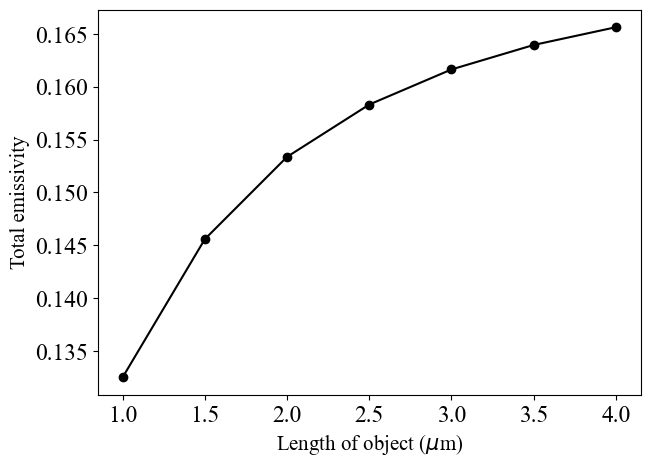

In [17]:
# Pre-allocations and constants

Nw = wSiO2.shape[0] # Number of frequency points
T = 300 # Temperature in Kelvin

Lx = 500 # X size of object, nm
Ly = 500 # Y size of object, nm

Lz_vect = np.array([1000,1500,2000,2500,3000,3500,4000]) # Z sizes of parals

Ln = 100 # Side of the dipole cubes, must be divisor of all three sides
Vn = (Ln*10**(-9))**3; # Dipole cube volume, in SI

emis_to_plot = np.zeros((7,Nw))
power_to_plot = np.zeros((7,))

for ape in range(7):
    
    Lz = Lz_vect[ape] # Z size of object, nm
    
    N = int(Lx*Ly*Lz/(Ln)**3) # Total number of dipoles

    Nx = int(Lx/Ln) # Number of dipoles in the x direction
    Ny = int(Ly/Ln) # Number of dipoles in the y direction
    Nz = int(Lz/Ln) # Number of dipoles in the z direction
    
    emission = np.zeros((Nw,)) # Will hold the emissivity values
    power = np.zeros((Nw,)) # Will hold the emission power values
    
    # TDDA calculations
    
    # Distributing the dipoles in space to form the cube
    
    posit = np.zeros((N,3)) # Holds all the positions

    maximx = np.floor(Nx/2) # How many dipoles until reaching the end of the x side
    maximy = np.floor(Ny/2) # How many dipoles until reaching the end of the y side
    maximz = np.floor(Nz/2) # How many dipoles until reaching the end of the z side

    for i in range(Nx):
    
        for j in range(Ny):
        
            for k in range(Nz):
            
                indexr = k + j*Nz + i*Nz*Ny
            
                posit[indexr,:] = np.array([i-maximx,j-maximy,k-maximz])

    posit = posit*Ln*10**(-9); # Actual locations of the cubes in SI

    # Calculate the emissivity and power

    for i in range(Nw):
    
        GG = np.zeros((3*N,3*N)).astype('complex'); # Pre-allocating the Green matrices
        dG = np.zeros((3*N,3*N)).astype('complex');
    
        # All dipoles are cubic, isotropic and equal in size: same a0,a,xi, and are diagonal
    
        k0 = wSiO2[i]*10**14/c # k value
    
        a0 = 3*Vn*(eps_SiO2[i]-1)/(eps_SiO2[i]+2) # Quasistatic polarizability tensor
        a = (a0)/(1-1j*k0**3*((a0)/(6*np.pi))) # Full polarizability tensor
    
        xi = np.imag(a)-(k0**3)/(6*np.pi)*np.abs(a)**2 
    
        AA = a*np.identity(3*N) # Full polarizabilty matrix
        XXi = xi*np.identity(3*N)
    
        # Calculate the Green's function values
    
        for j in range(N):
        
            for k in range(N):
            
                index_j = np.array([[3*j,3*j,3*j],[3*j+1,3*j+1,3*j+1],[3*j+2,3*j+2,3*j+2]]).astype(int)
                index_k = np.array([[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2],[3*k,3*k+1,3*k+2]]).astype(int)
            
                if j == k:
                
                    GG[index_k,index_j] = ((-1)/(3*k0**2*Vn)+(1j*k0)/(6*np.pi))*np.identity(3)
                
                else:
                
                    tempG = Gfunct(posit[j,:],posit[k,:],k0)
                    GG[index_k,index_j] = tempG
                    dG[index_k,index_j] = tempG
        
        D = np.linalg.inv(np.identity(3*N)-k0**2*np.matmul(dG,AA))
    
        emission_raw = 2*np.pi*np.trace(np.matmul(D,np.matmul(np.imag(GG),np.matmul(np.conjugate(np.transpose(D)),XXi))))
    
        emission[i] = emission_raw/((Lx*10**(-9)*Lz*10**(-9))) # Emissivity of the cube
    
        power[i] = 4*np.pi*emission_raw*IBB(wSiO2[i]*10**14,T) # Spectral power emitted by the cube
    
    total_emiss = np.sum(power)*(wSiO2[1]-wSiO2[0])*10**14/((2*Lx*10**(-9)*Ly*10**(-9)+4*Lx*10**(-9)*Lz*10**(-9))*5.67*10**(-8)*T**4) # Total emissivity of the cube
    
    emis_to_plot[ape,:] = np.reshape(emission,(1,Nw))
    power_to_plot[ape] = total_emiss

plt.rcParams['font.family'] = ['Times New Roman']
fig,axs = plt.subplots(1,1,figsize=(7,5))
axs.plot(Lz_vect/1000,power_to_plot,'-o',color='black')
axs.set_ylabel('Total emissivity', fontsize = 20)
axs.set_xlabel('Length of object ($\mu$m)', fontsize = 20)
axs.tick_params(axis='both', labelsize = 20)
fig.savefig('TDDA_paral_emis_long.png', format='png', dpi=600)
plt.show()